In [ ]:
'''This notebook allows you to build a time series model. Predict the daily behavior of the series in the next 3 months.'''

In [1]:
import pandas as pd
import numpy as np
import statsmodels 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
# Load data
data = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Timeseries")
data = data.rename(columns={'Date': 'date', 'series1': 'series'})
data['date'] = pd.to_datetime(data['date'])                        # change to datetime object (datetime64)
data.set_index('date', inplace=True)                               # pick column "Date" how label (inplace=True  for don't creating new df)

In [100]:
data.iloc[1314]

series    4322.886728
Name: 2018-08-07 00:00:00, dtype: float64

In [3]:
mean1 = data.iloc[0:820].mean()
mean2 = data.iloc[821:].mean()
print(mean1)
print(mean2)
print("%:", ((mean2 - mean1) / mean1 * 100))

mean3 = data.iloc[0:820].std()
mean4 = data.iloc[821:].std()
print(mean3)
print(mean4)
print("%:", ((mean4 - mean3) / mean3 * 100))


series    3646.937261
dtype: float64
series    4062.189723
dtype: float64
%: series    11.386334
dtype: float64
series    1152.256384
dtype: float64
series    1285.014839
dtype: float64
%: series    11.521607
dtype: float64


In [99]:
# dataframe information
print(data)
print(data.describe())
print("\nКоличество нулевых значений в каждом столбце:")
print("None:", data.isnull().sum(), "\nNaN:", data.isna().sum())

                 series
date                   
2015-01-01  1006.699649
2015-01-02  3197.751826
2015-01-03  3217.491035
2015-01-04  2151.573759
2015-01-05  4243.929892
...                 ...
2019-06-26  4007.059387
2019-06-27  4836.106157
2019-06-28  4895.323783
2019-06-29  4086.016222
2019-06-30  3572.796793

[1642 rows x 1 columns]
             series
count   1642.000000
mean    3854.975154
std     1237.337605
min      236.870506
25%     3138.534200
50%     3632.014420
75%     4258.734299
max    12652.832842

Количество нулевых значений в каждом столбце:
None: series    0
dtype: int64 
NaN: series    0
dtype: int64


In [ ]:
data

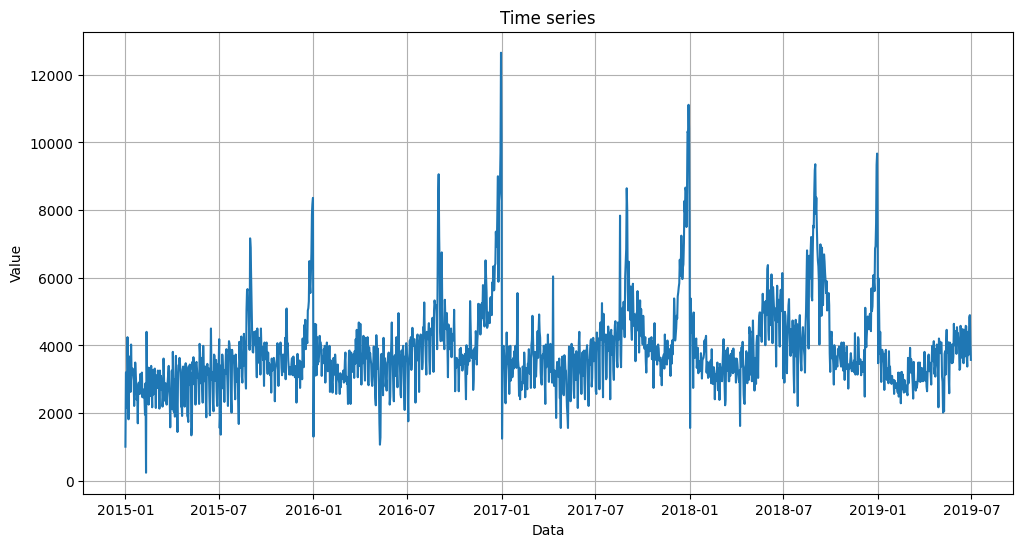

In [9]:
#visualization time series for checking of trend

plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title("Time series")
plt.xlabel("Data")
plt.ylabel("Value")
plt.grid()
plt.show()

In [3]:
# for estimating stationarity of time series
result = adfuller(data['series'])  
# print("ADF Statistic:", result[0])
# print("p-value:", result[1])


print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.496714
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


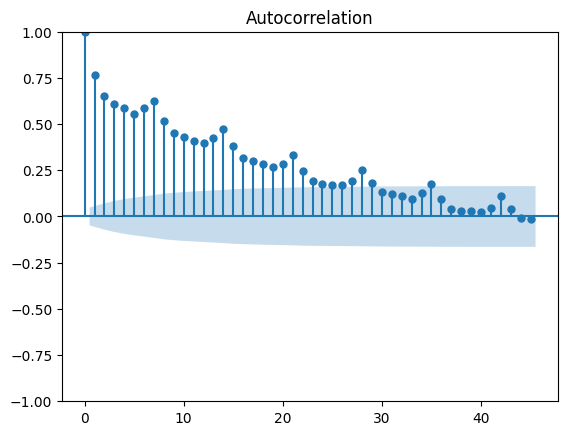

In [4]:
# check autocorrelation of data 
plot_acf(data, lags=45)
plt.show()

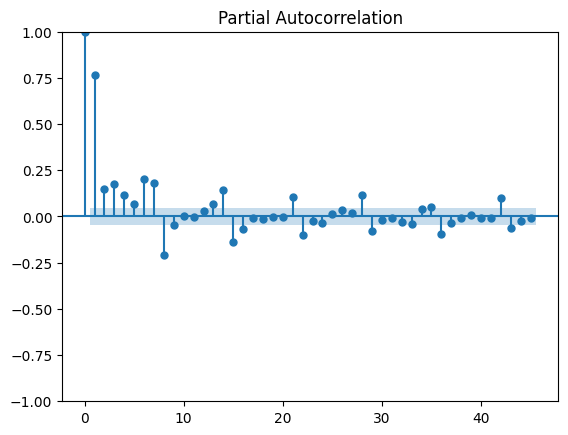

In [5]:
# check autocorrelation of data 
plot_pacf(data, lags= 45)
plt.show()

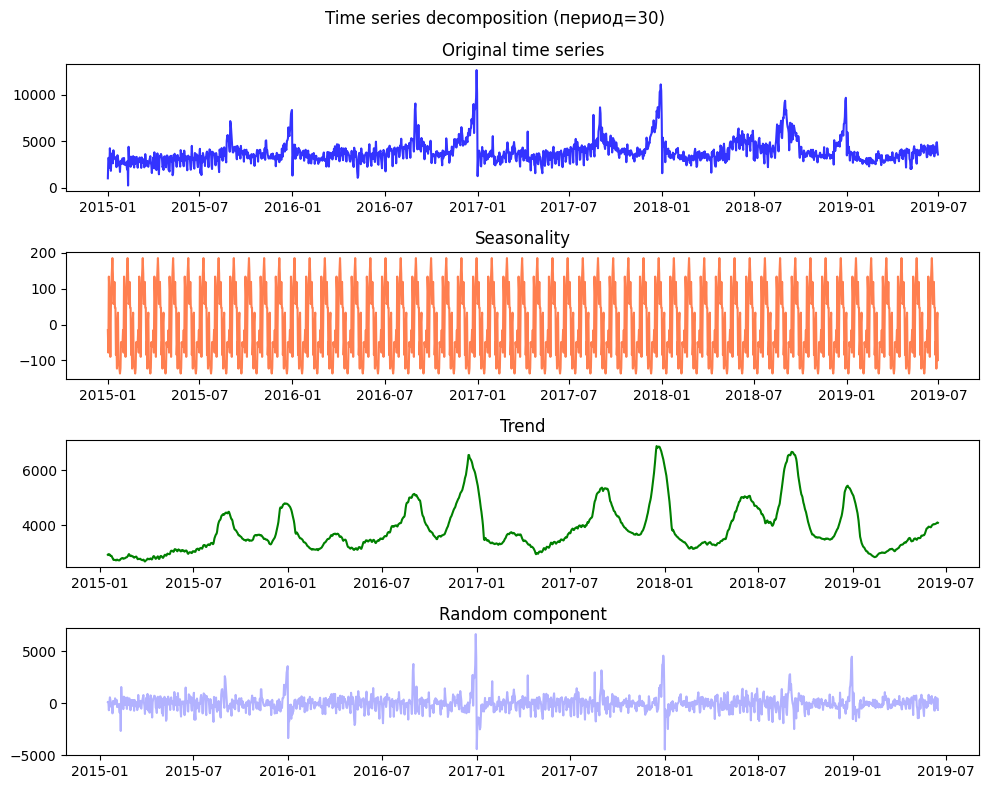

In [6]:
# decompose time series to component

def decompose(series, period):
    decomposition = seasonal_decompose(series, period=period, model='additive')
    
    fig, axs = plt.subplots(4, 1, figsize=(10, 8))

    axs[0].plot(series, color='blue', alpha=0.8)
    axs[0].set_title('Original time series')

    axs[1].plot(decomposition.seasonal, color='coral')
    axs[1].set_title('Seasonality')

    axs[2].plot(decomposition.trend, color='green')
    axs[2].set_title('Trend')

    axs[3].plot(decomposition.resid, color='blue', alpha=0.3)
    axs[3].set_title('Random component')

    plt.suptitle(f"Time series decomposition (период={period})")
    plt.tight_layout()
    plt.show()


decompose(data, period=30)

In [3]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = data[:'2018-08-07']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = data['2018-08-08':]

In [ ]:
from pmdarima import auto_arima

model = auto_arima(
    data,
    start_p=0, max_p=20,  # AR (p)
    start_q=0, max_q=20,  # MA (q)
    d=None,              # Автовыбор d (если None)
    seasonal=True,      # Не используем сезонность (SARIMA)
    trace=True,          # Вывод процесса подбора
    error_action="ignore",
    stepwise=True        # Ускоренный поиск
)
print(model.summary())

In [139]:
# model of time series
model = ARIMA(train, order=(7, 1, 7))  
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 series   No. Observations:                 1315
Model:                 ARIMA(7, 1, 7)   Log Likelihood              -10452.124
Date:                Tue, 12 Aug 2025   AIC                          20934.249
Time:                        15:28:05   BIC                          21011.961
Sample:                    01-01-2015   HQIC                         20963.391
                         - 08-07-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4519      0.032    -14.126      0.000      -0.515      -0.389
ar.L2         -0.4529      0.035    -13.070      0.000      -0.521      -0.385
ar.L3         -0.4622      0.033    -13.797      0.0

In [4]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод predict
predictions = result.predict(start, end)
predictions

NameError: name 'result' is not defined

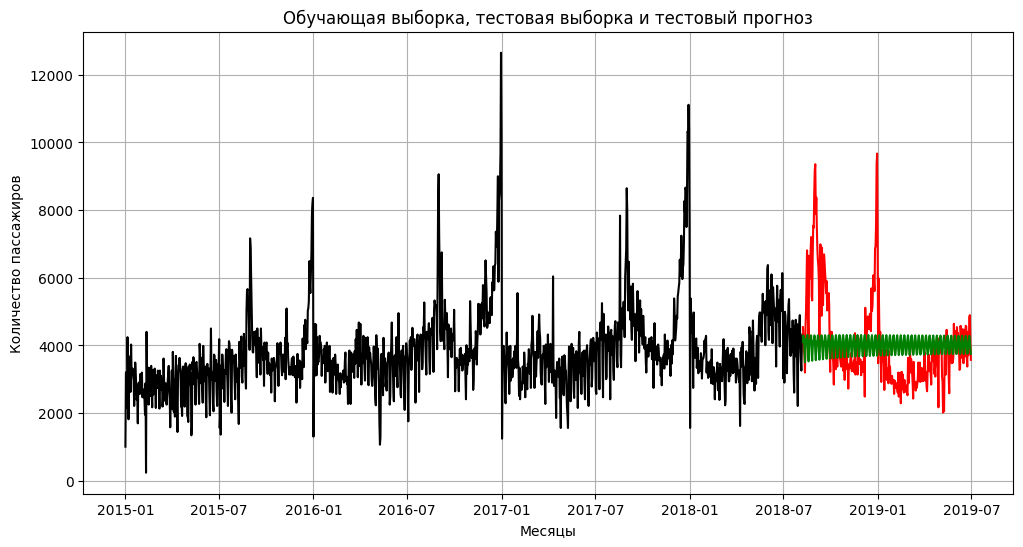

In [141]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(12, 6))
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')

# заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [37]:
# импортируем метрику
from sklearn.metrics import mean_squared_error

# рассчитаем MSE
print(mean_squared_error(test, predictions))

# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

1791792.7545651023
1338.5786321935302


In [38]:
# прогнозный период начнется с конца имеющихся данных
start = len(data)

# и закончится 36 месяцев спустя
end = (len(data) - 1) + 90

# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1963 год
forecast[-12:]

2019-09-17    4211.179552
2019-09-18    4329.780708
2019-09-19    4405.022769
2019-09-20    4456.342890
2019-09-21    3998.163090
2019-09-22    3330.758157
2019-09-23    4212.101980
2019-09-24    4211.179552
2019-09-25    4329.780708
2019-09-26    4405.022769
2019-09-27    4456.342890
2019-09-28    3998.163090
Freq: D, Name: predicted_mean, dtype: float64

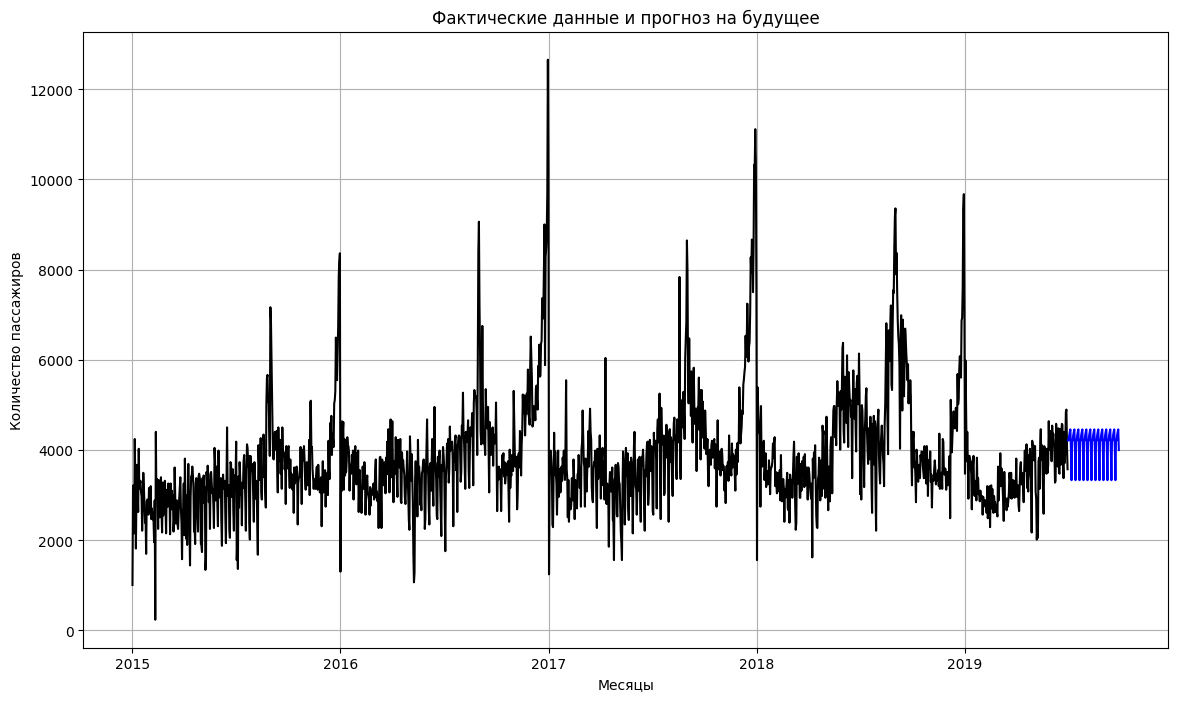

In [39]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize=(14, 8))
plt.plot(data, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [7]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = data[:'2018-08-07']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = data['2018-08-08':]


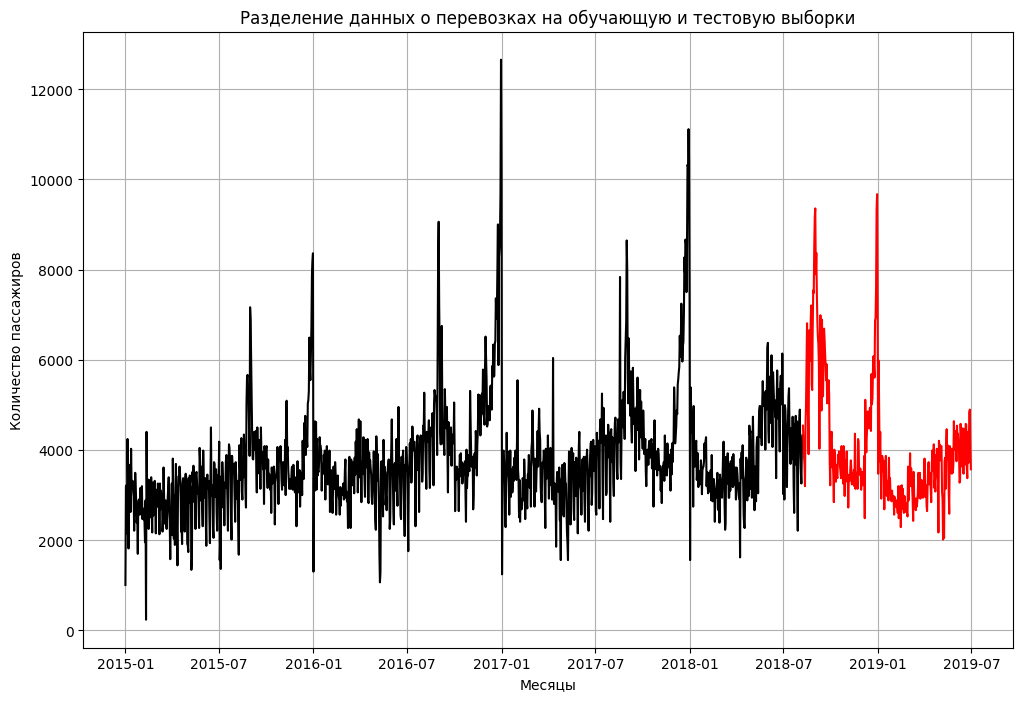

In [8]:
# выведем эти данные на графике
plt.figure(figsize=(12, 8))
plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()
     

In [29]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima


# "погасим" предупреждения
import warnings
warnings.filterwarnings("ignore")

# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 10, max_q = 10, m = 10, start_P = 0, seasonal = True,
                         d = 0, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #

# выведем результат
print(parameter_search.summary())
     

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[10] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,0,0)(0,1,0)[10] intercept   : AIC=22485.094, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[10] intercept   : AIC=21675.087, Time=0.67 sec
 ARIMA(0,0,1)(0,1,1)[10] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[10]             : AIC=22483.184, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[10] intercept   : AIC=21969.872, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[10] intercept   : AIC=21573.877, Time=1.78 sec
 ARIMA(1,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=4.72 sec
 ARIMA(1,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(2,1,0)[10] intercept   : AIC=22221.750, Time=2.60 sec
 ARIMA(2,0,0)(2,1,0)[10] intercept   : AIC=21569.558, Time=2.18 sec
 ARIMA(2,0,0)(1,1,0)[10] intercept   : AIC=21661.969, Time=0.91 sec
 ARIMA(2,0,0)(2,1,1)[10] intercept   : AIC=21378.885, Time=4.74 sec
 ARIMA(2,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(2,0,0)(2,1,2)[10] intercept 

In [53]:

     # принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(train,
                order = (2, 1, 2),
                seasonal_order = (2, 1, 1, 2))

# применим метод fit
result = model.fit()

ValueError: Invalid model: autoregressive lag(s) {2} are in both the seasonal and non-seasonal autoregressive components.

In [41]:
# мы можем посмотреть результат с помощью метода summary()
print(result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              series   No. Observations:                 1315
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 3)   Log Likelihood              -10605.786
Date:                             Tue, 12 Aug 2025   AIC                          21227.572
Time:                                     16:07:55   BIC                          21269.000
Sample:                                 01-01-2015   HQIC                         21243.109
                                      - 08-07-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2327      0.102     12.059      0.000       1.032       1.433
ar.L2         -0.2912      

In [42]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод predict
predictions = result.predict(start, end)
predictions

2018-08-08    4222.189226
2018-08-09    4129.028485
2018-08-10    4076.224915
2018-08-11    4071.905590
2018-08-12    4146.282823
                 ...     
2019-06-26    4655.359807
2019-06-27    4635.262604
2019-06-28    4639.749224
2019-06-29    4659.305053
2019-06-30    4639.207850
Freq: D, Name: predicted_mean, Length: 327, dtype: float64

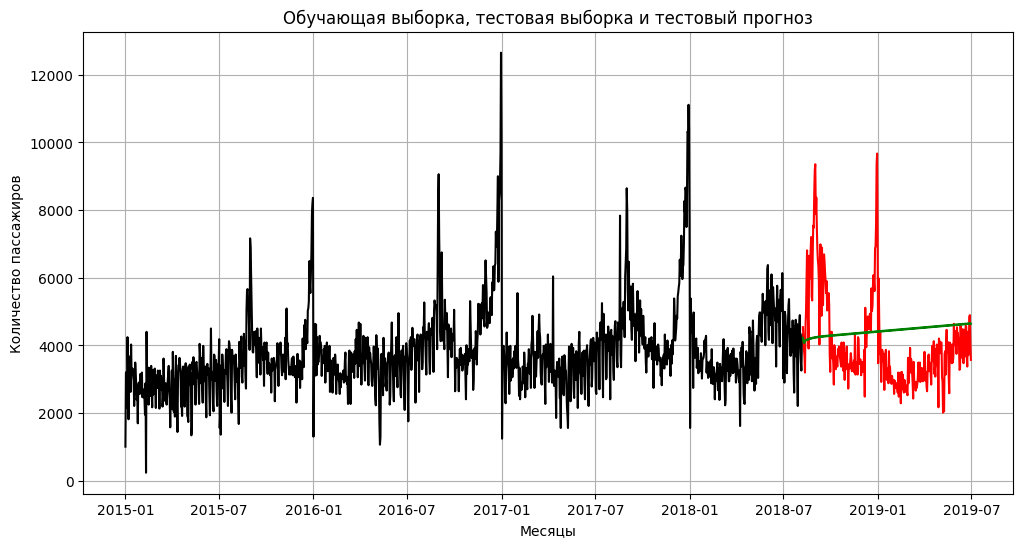

In [43]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(12, 6))
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')

# заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [14]:
# импортируем метрику
from sklearn.metrics import mean_squared_error

# рассчитаем MSE
print(mean_squared_error(test, predictions))

# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

1812197.1549921976
1346.1787232727302


In [15]:
# прогнозный период начнется с конца имеющихся данных
start = len(data)

# и закончится 36 месяцев спустя
end = (len(data) - 1) + 90

# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1963 год
forecast[-12:]

2019-09-17    4080.091303
2019-09-18    4098.607719
2019-09-19    4028.655200
2019-09-20    4192.953257
2019-09-21    3996.744613
2019-09-22    3929.662911
2019-09-23    3753.652931
2019-09-24    3817.870556
2019-09-25    3669.316256
2019-09-26    3686.040094
2019-09-27    3868.537389
2019-09-28    3729.079661
Freq: D, Name: predicted_mean, dtype: float64

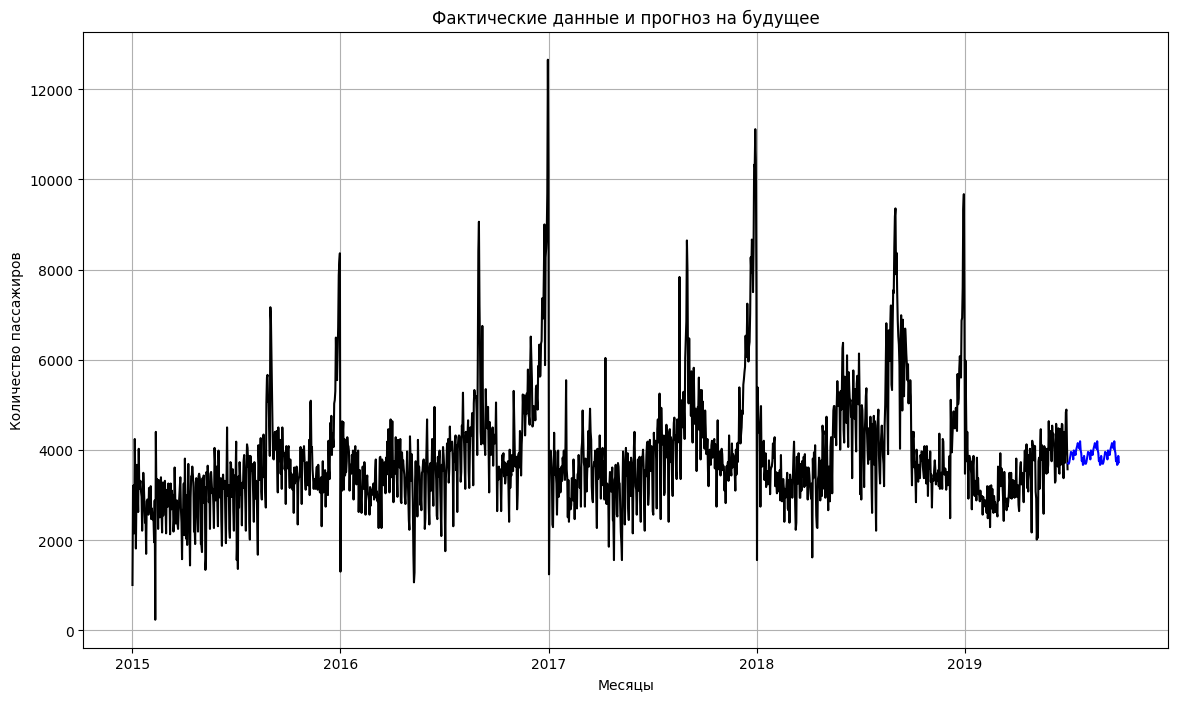

In [16]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize=(14, 8))
plt.plot(data, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [18]:
from sklearn.metrics import r2_score
print(r2_score(test, predictions))

-0.009106799969013979


In [64]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [67]:
def search_optimal_sarima(time_series, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = statsmodels.tsa.statespace.SARIMAX(time_series,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 7
search_optimal_sarima(train, seasonal_cycle_length)

ARIMANonexNone - AIC:inf


In [54]:
#create new DataFrame
monthly_OS = pd.DataFrame()

monthly_OS['Sales'] = data['series'].resample('MS').mean()

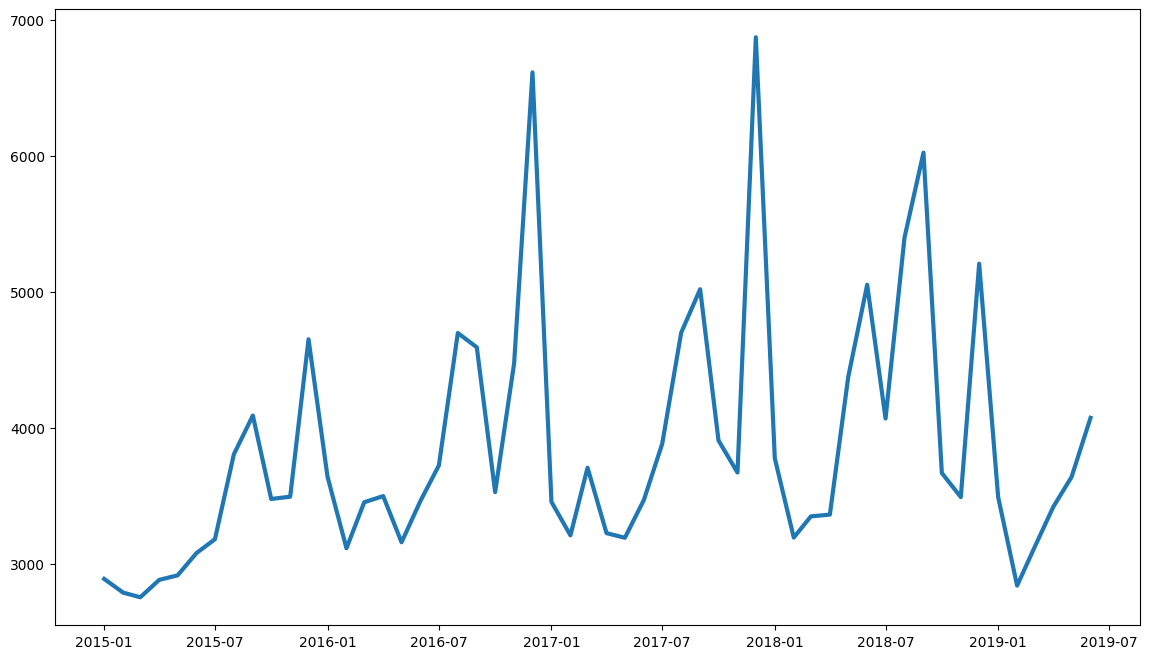

In [56]:
#plot weekly sales data
plt.figure(figsize=(14, 8))
plt.plot(monthly_OS.index, monthly_OS.Sales, linewidth=3)

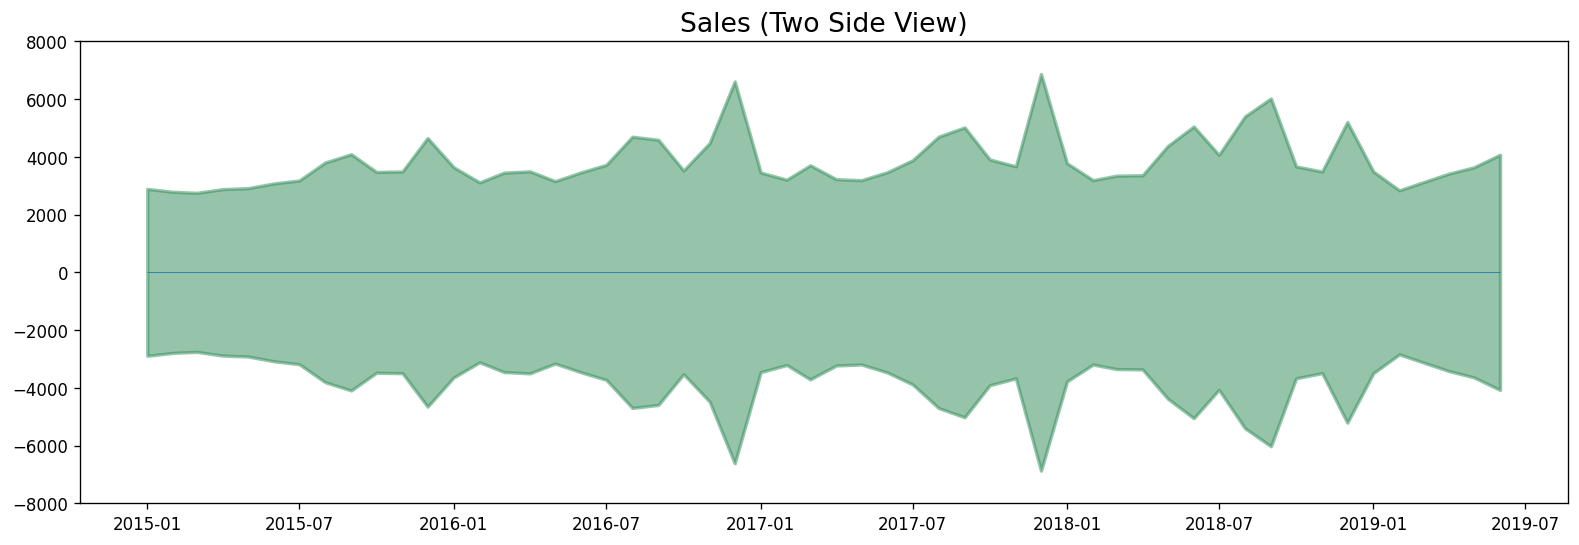

In [58]:
x= monthly_OS.index
y1= monthly_OS['Sales'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-8000, 8000)
plt.title('Sales (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(monthly_OS.index), xmax=np.max(monthly_OS.index), linewidth=.5)
plt.show()

In [59]:
data['year'] = [d.year for d in data.index]
data['month'] = [d.strftime('%b') for d in data.index]
years= data['year'].unique()
years

array([2015, 2016, 2017, 2018, 2019], dtype=int64)

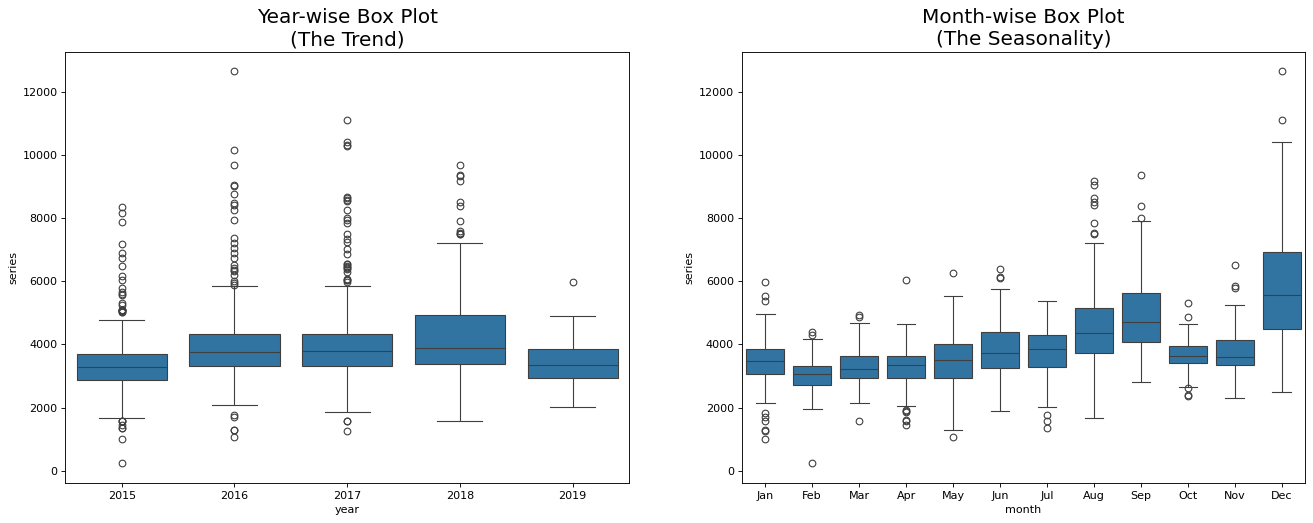

In [61]:

import seaborn as sns
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='series', data=data, ax=axes[0])
sns.boxplot(x='month', y='series', data=data.loc[~data.year.isin([2014,2917]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

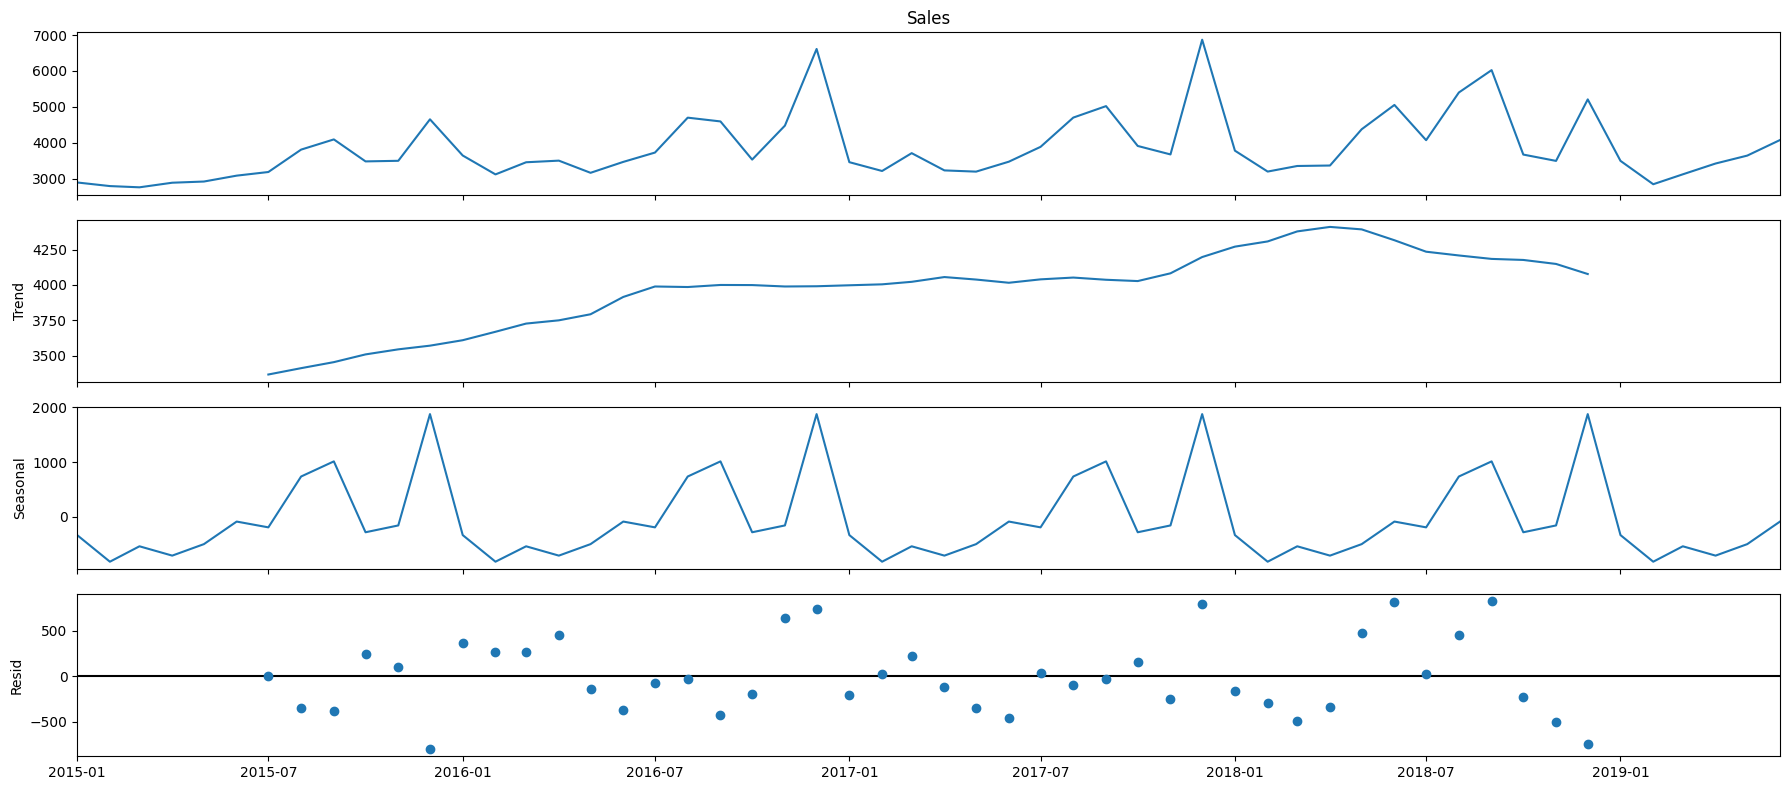

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = statsmodels.tsa.seasonal.seasonal_decompose(monthly_OS['Sales'], model='additive')
fig = decomposition.plot()
plt.show()

In [64]:
#Determing rolling statistics
moving_avg = monthly_OS.rolling(12).mean()
moving_std= monthly_OS.rolling(12).std()

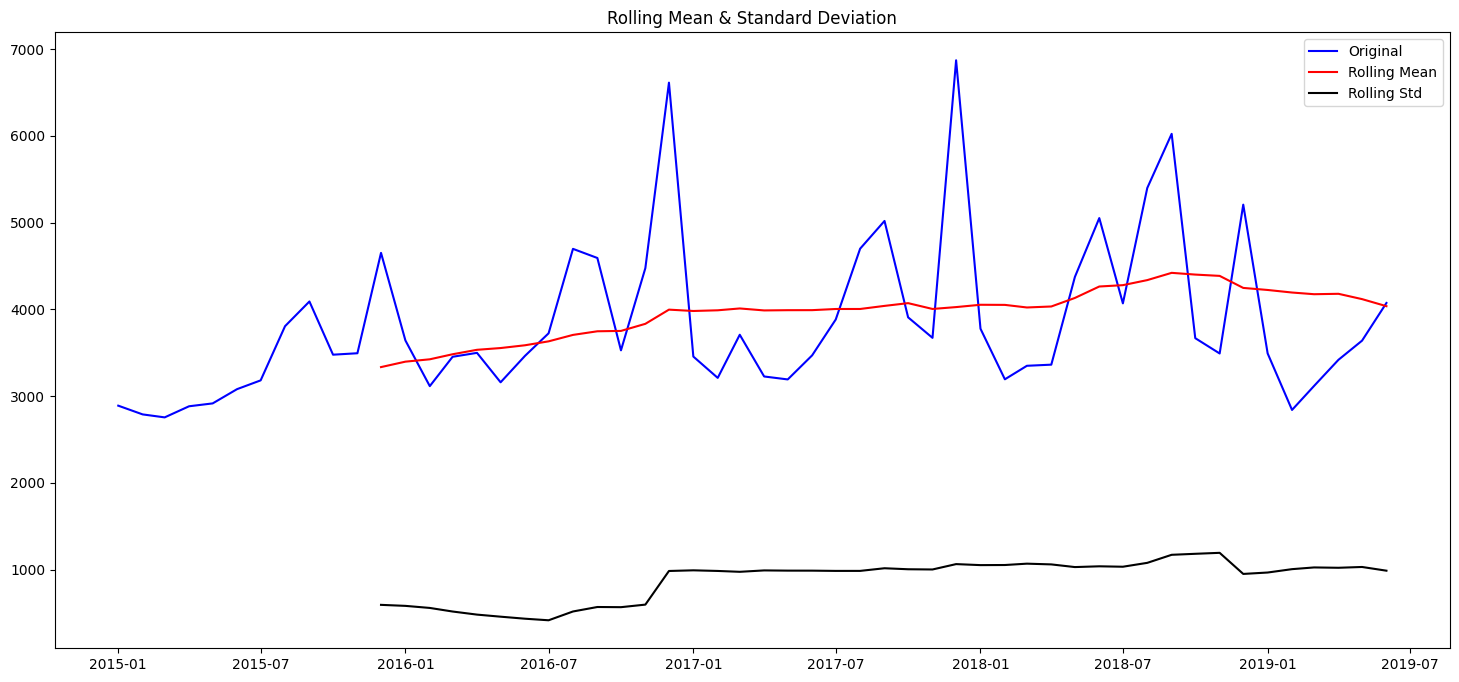

In [65]:
#Plot rolling statistics:
orig = plt.plot(monthly_OS, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [66]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(monthly_OS, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.221182
p-value                         0.198648
#Lags Used                     11.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64


In [118]:
#create new DataFrame:
data.index = pd.to_datetime(data.index)

y = data['series'].resample('MS').mean()

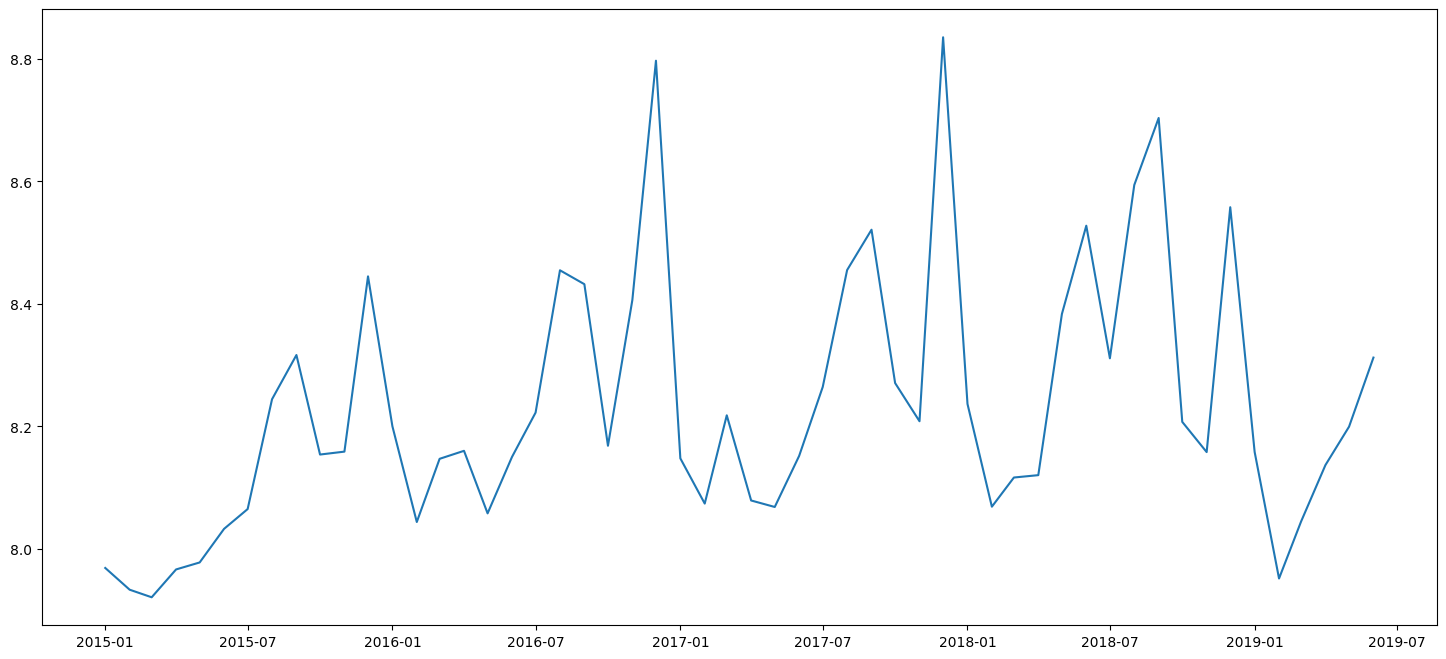

In [89]:
## Lets take a log transform here for simplicity:
ts_log = np.log(y)
plt.plot(ts_log)

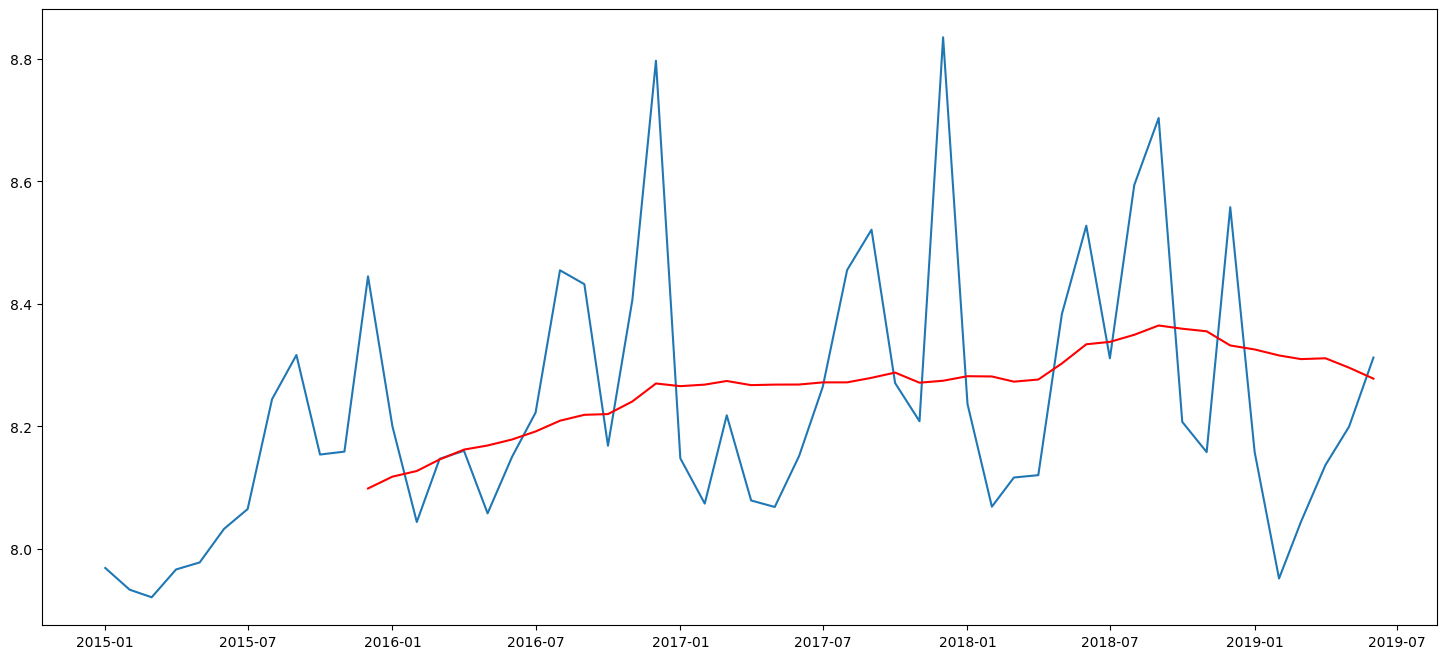

In [69]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [70]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

date
2015-01-01         NaN
2015-02-01         NaN
2015-03-01         NaN
2015-04-01         NaN
2015-05-01         NaN
2015-06-01         NaN
2015-07-01         NaN
2015-08-01         NaN
2015-09-01         NaN
2015-10-01         NaN
2015-11-01         NaN
2015-12-01    0.346187
Freq: MS, Name: series, dtype: float64

In [71]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print ('Results of Dickey-Fuller Test:')
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

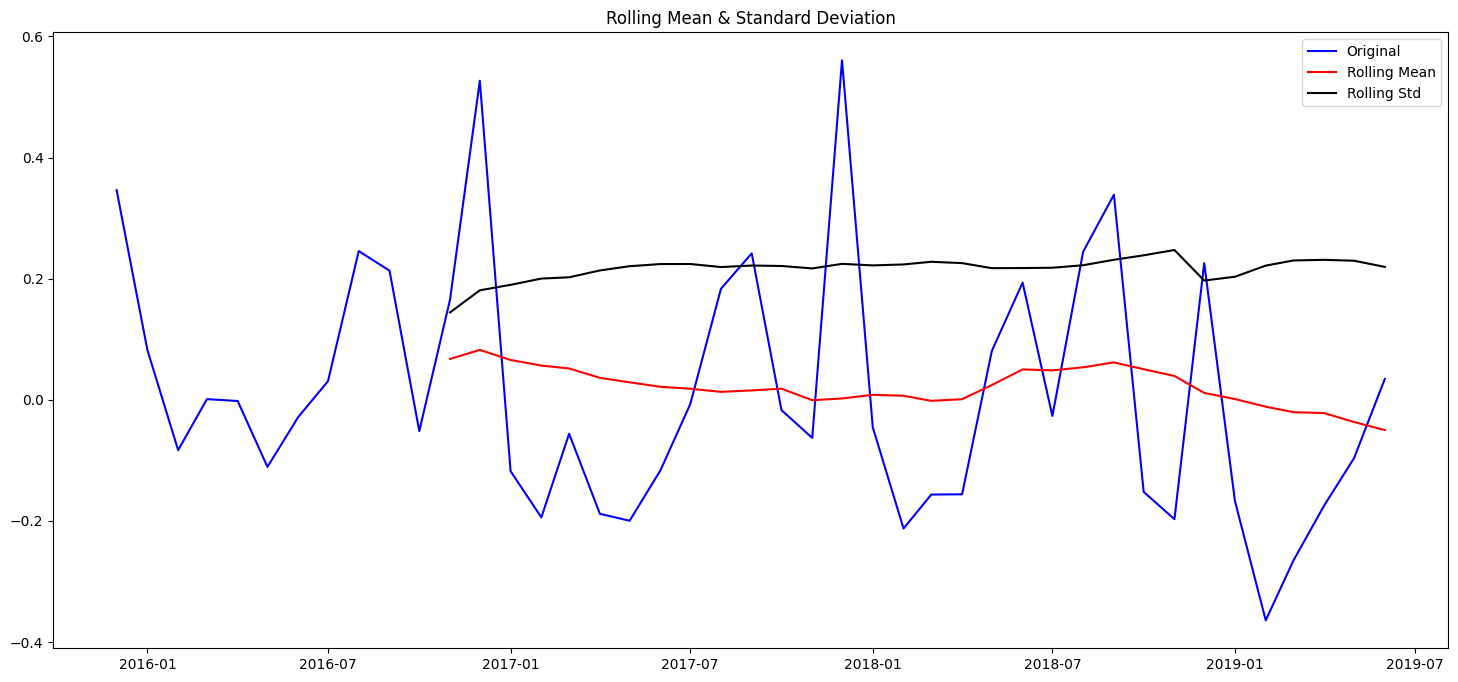

Results of Dickey-Fuller Test:
Test Statistic                 -4.547014
p-value                         0.000162
#Lags Used                      6.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [72]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

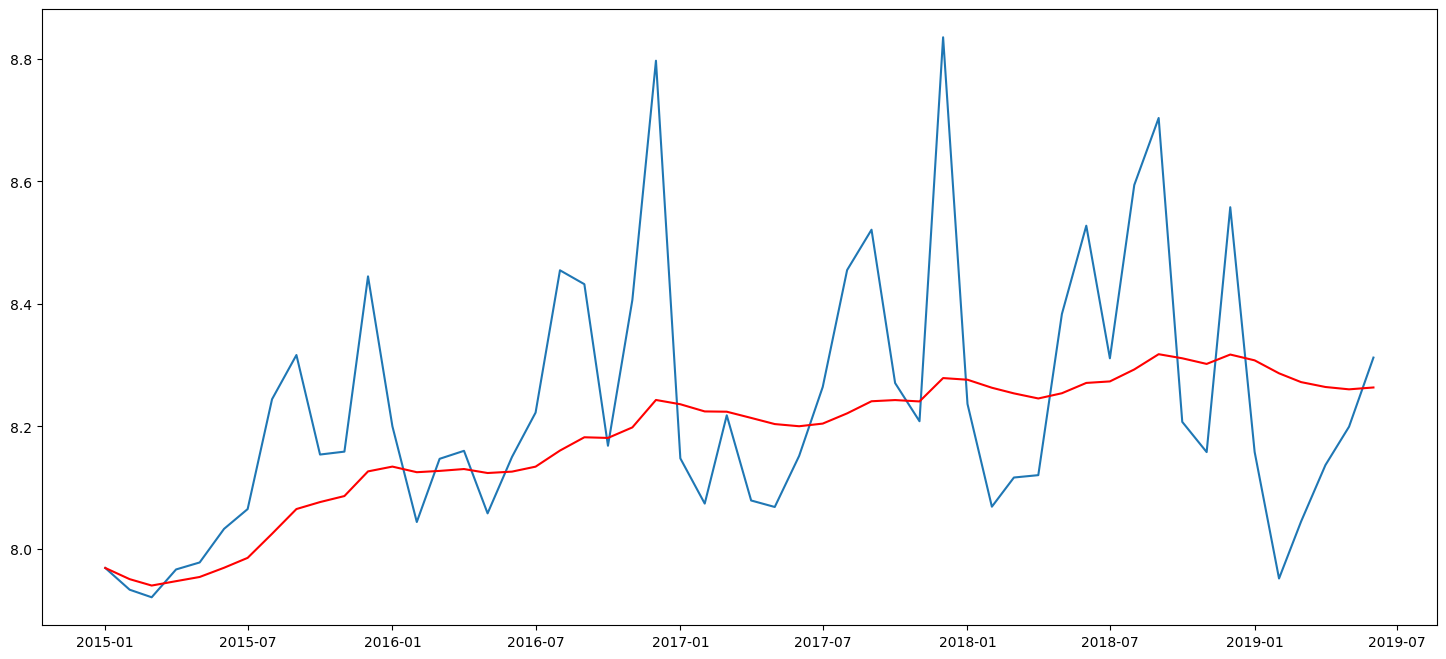

In [73]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

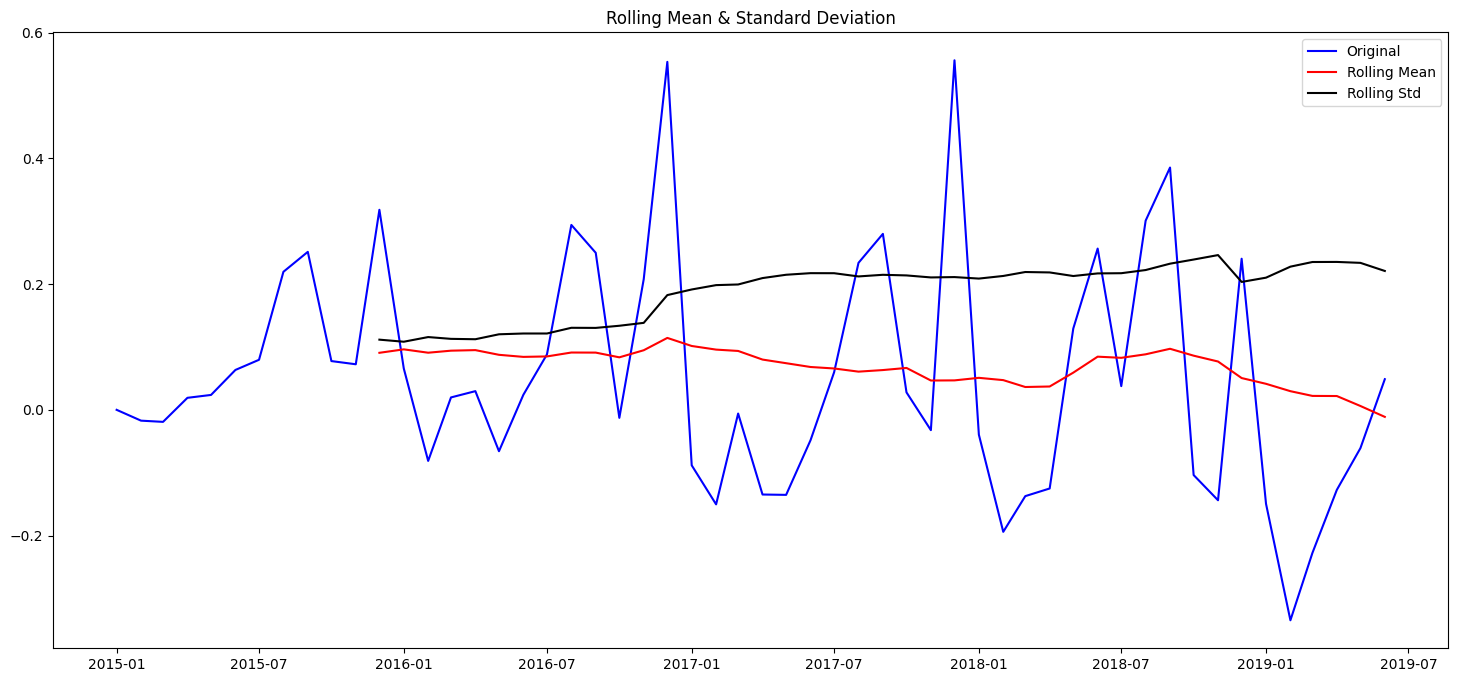

Results of Dickey-Fuller Test:
Test Statistic                  0.317615
p-value                         0.978138
#Lags Used                     11.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64


In [74]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

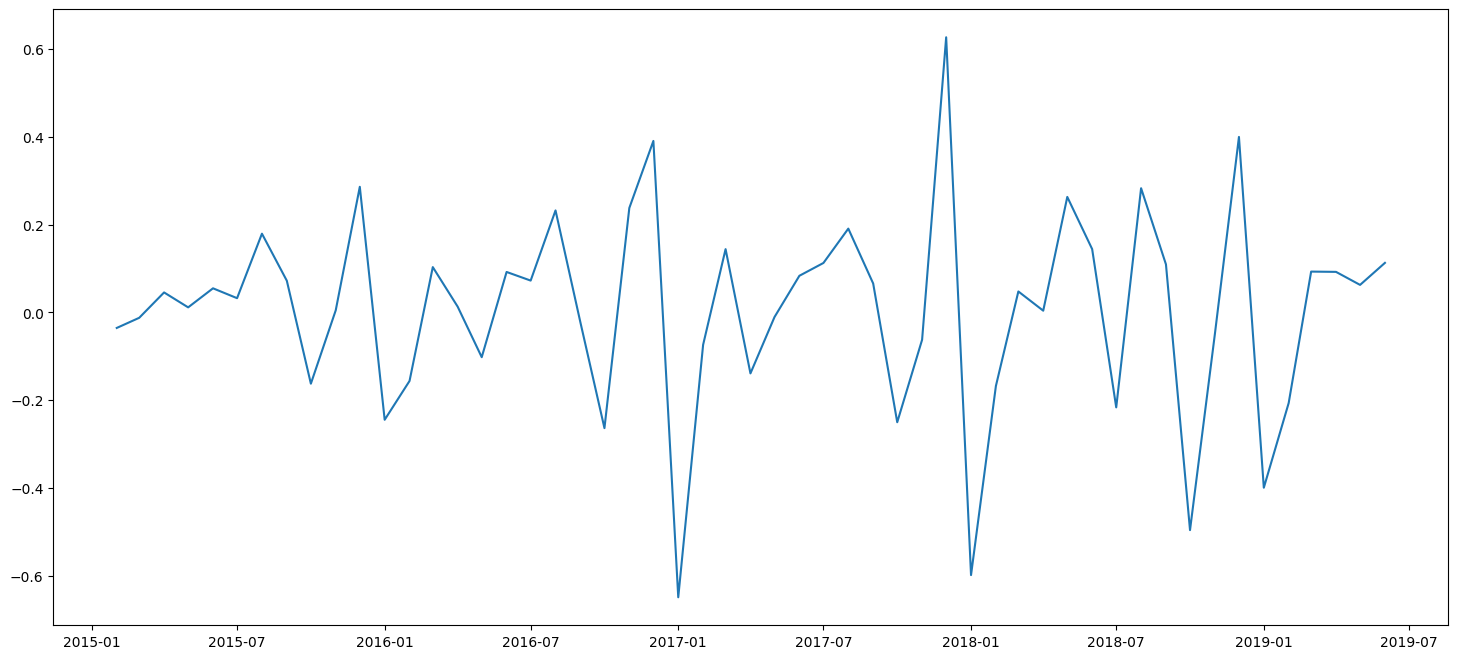

In [75]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

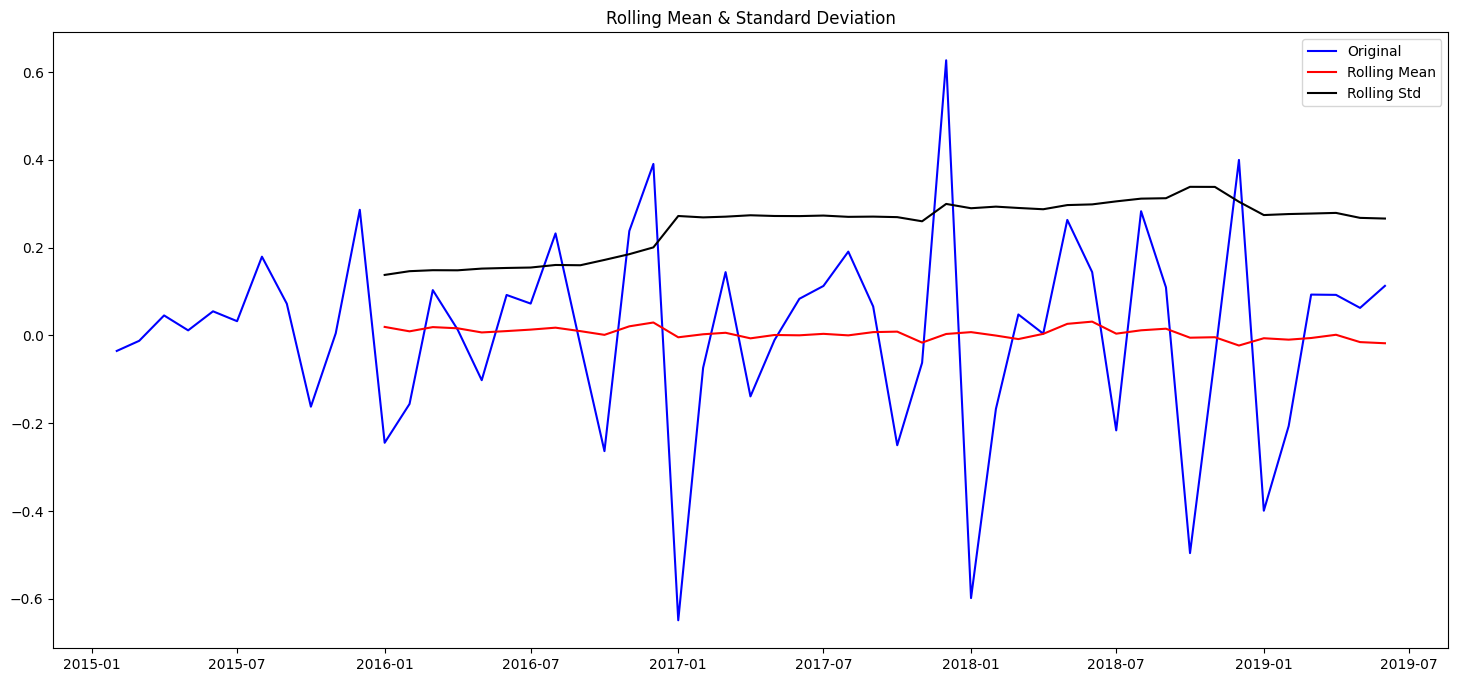

Results of Dickey-Fuller Test:
Test Statistic                 -2.357366
p-value                         0.154133
#Lags Used                     11.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [76]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

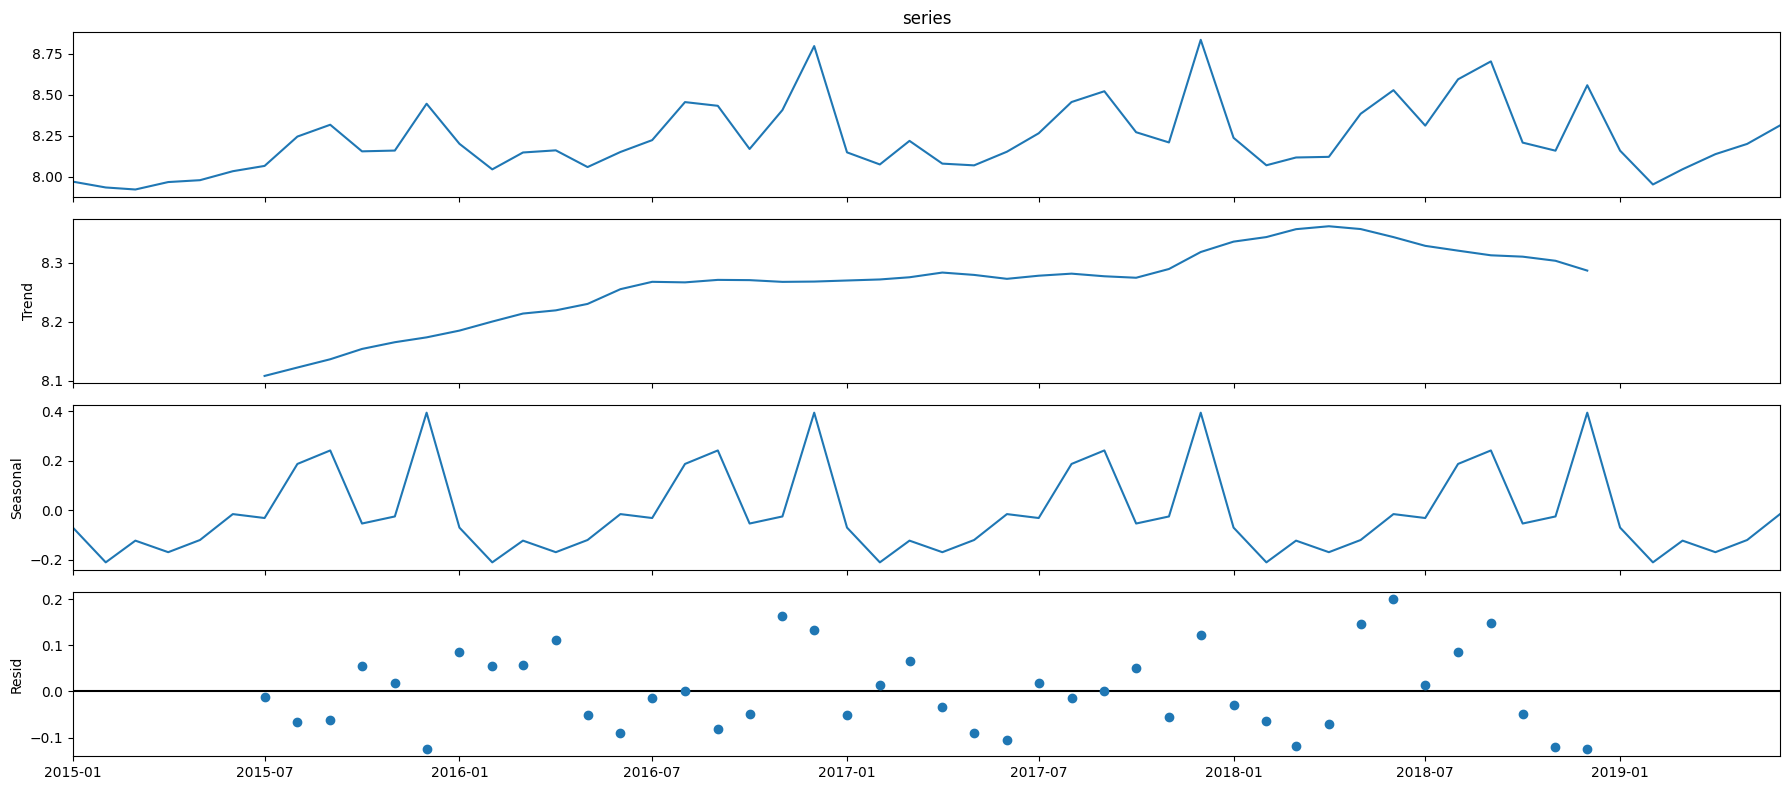

In [77]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts_log, model='additive')
fig = decomposition.plot()
plt.show()

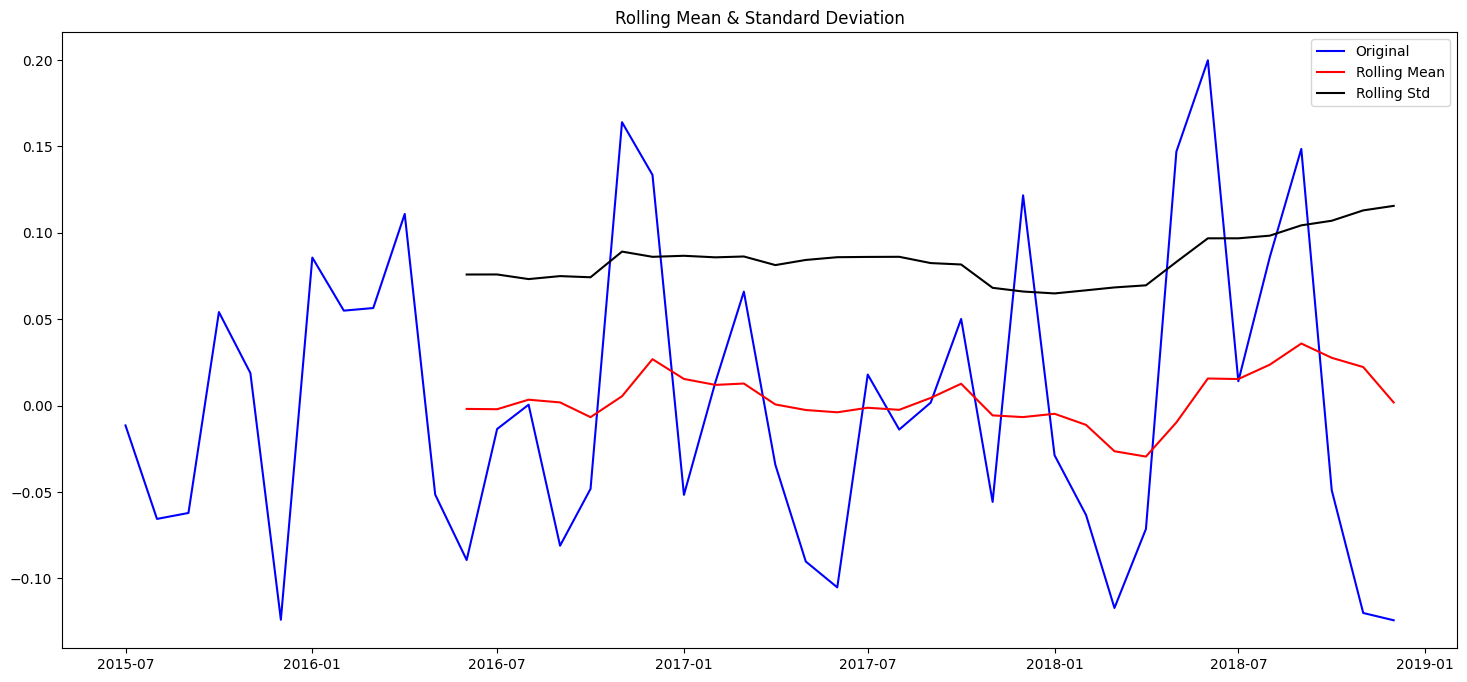

Results of Dickey-Fuller Test:
Test Statistic                 -5.262141
p-value                         0.000007
#Lags Used                      5.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
residual = decomposition.resid

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [129]:

train = y[:43]
test = y[45:]


In [131]:
print (len(y))
print(len (train))
print(len (test))

54
43
9


In [82]:
auto_arima(train, test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=879.058, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=894.405, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=891.918, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=880.109, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=892.428, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=877.140, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=880.989, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=878.362, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=876.611, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=876.175, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=878.725, Time=0.02 se

,order,"(0, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,False


In [83]:
auto_arima(y,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=879.058, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=894.405, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=891.918, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=880.109, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=892.428, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=877.140, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=880.989, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=878.362, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=876.611, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=876.175, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=878.725, Time=0.02 se

,order,"(0, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,False


In [84]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train, order=(1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 series   No. Observations:                   54
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.225
Date:                Tue, 12 Aug 2025   AIC                            878.450
Time:                        16:58:06   BIC                            884.361
Sample:                    01-01-2015   HQIC                           880.723
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2460      0.203      1.214      0.225      -0.151       0.643
ma.L1         -0.8827      0.118     -7.480      0.000      -1.114      -0.651
sigma2      7.929e+05   1.42e+05      5.584      0.000    5.15e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.93
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               3.12   Skew:                             0.81
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод predict
predictions = result.predict(start, end)
predictions

In [96]:
pre=result.predict(start= len(train), end= (len(train)+len(y)-1),dynamic=True)
pre

2015-02-24    2685.783916
2015-02-25    2928.982269
2015-02-26    3220.587866
2015-02-27    2697.543633
2015-02-28    2901.274670
2015-03-01    3256.397951
2015-03-02    2745.232523
2015-03-03    2990.041072
2015-03-04    3294.762550
2015-03-05    2786.632493
2015-03-06    3027.409914
2015-03-07    3336.461768
2015-03-08    2828.359135
2015-03-09    3071.117067
2015-03-10    3376.567338
2015-03-11    2868.180694
2015-03-12    3110.227990
2015-03-13    3415.634857
2015-03-14    2906.902701
2015-03-15    3148.761076
2015-03-16    3453.659546
2015-03-17    2944.648527
2015-03-18    3186.222181
2015-03-19    3490.904465
2015-03-20    2981.673207
2015-03-21    3223.053796
2015-03-22    3527.538625
2015-03-23    3018.138453
2015-03-24    3259.362675
2015-03-25    3563.707696
2015-03-26    3054.178108
2015-03-27    3295.284572
2015-03-28    3599.520635
2015-03-29    3089.892177
2015-03-30    3330.908139
2015-03-31    3635.061693
2015-04-01    3125.357703
2015-04-02    3366.304659
2015-04-03  

In [81]:
import statsmodels.api as sm
model1=sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,12))

results=model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             series   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -322.406
Date:                            Tue, 12 Aug 2025   AIC                            654.812
Time:                                    16:56:18   BIC                            663.380
Sample:                                01-01-2015   HQIC                           657.932
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2913      0.239      1.218      0.223      -0.177       0.760
ma.L1         -0.8210      0.240     -3.421      0.001      -1.291      -0.351
ar.S.L12      -0.8351      0.440     -1.900      0.057      -1.697       0.027
ma.S.L12       0.9726      0.350      2.778      0.005       0.286       1.659
sigma2      3.638e+05   1.88e-06   1.93e+11      0.000    3.64e+05    3.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.04
Prob(Q):                              0.68   Prob(JB):                         0.59
Heteroskedasticity (H):               1.72   Skew:                            -0.28
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.7e+26. Standard errors may be unstable.
"""

In [132]:
# start = len(train)

# # и закончится в конце тестового
# end = len(train) + len(test) - 1

# # применим метод predict
# pre = result.predict(start, end)
# pre


pre=results.predict(start= len(train), end = (len(train)+len(test)-1),dynamic=True)
pre

date
2018-08-01    5016.904144
2018-09-01    5457.142989
2018-10-01    4375.951543
2018-11-01    3976.852655
2018-12-01    7252.688555
2019-01-01    4257.281868
2019-02-01    3592.559058
2019-03-01    3731.285435
2019-04-01    3825.197394
Freq: MS, Name: predicted_mean, dtype: float64

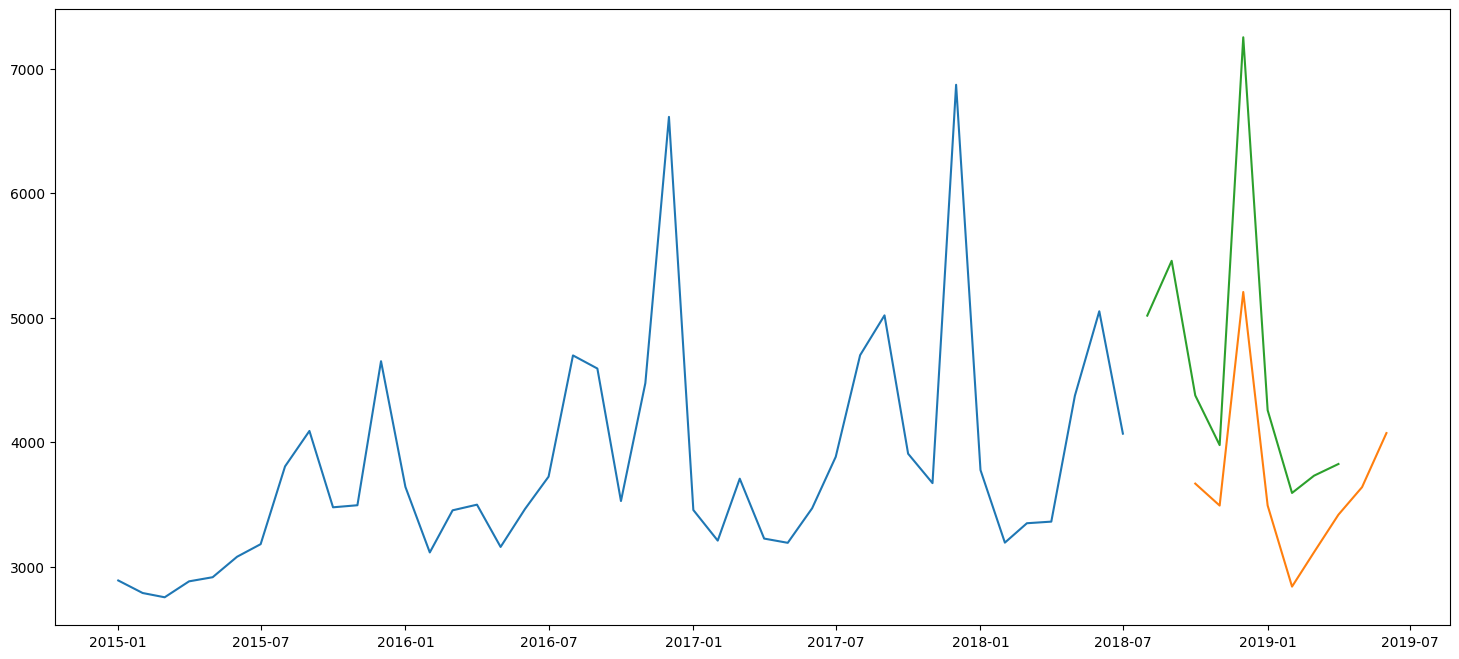

In [133]:
plt.plot(train,  label='Train')

plt.plot(test,  label='Train')

plt.plot(pre,  label='Train')

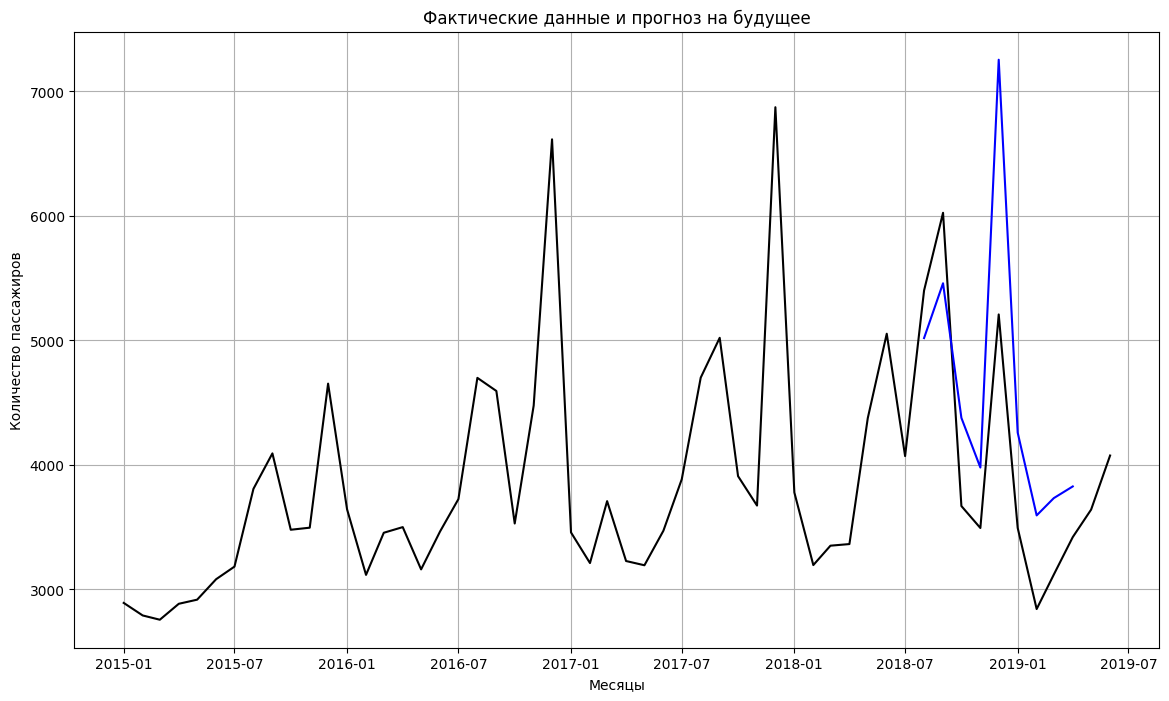

In [134]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.figure(figsize=(14, 8))
plt.plot(y, color = 'black')
plt.plot(pre, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()